In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

In [ ]:
print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)

In [ ]:
tf.config.list_physical_devices()

## Las CNNs se enfrentan a MNIST

Vamos a reutilizar el conjunto de datos MNIST de números escritos a mano y a entrenar una red neuronal convolucional simple para clasificarlos.

Acá, el objetivo es intentar comprender cómo funciona la red, por lo que elegiremos una arquitectura relativamente simple.

### Preparación de los datos

In [23]:
(X_train, t_train), (X_val, t_val) = keras.datasets.mnist.load_data()

Las etiquetas en `t_train` y `t_val` son números entre 0 y 9.

Lo primero que vamos a hacer es convertirlos a un encoding *1-de-K*. Para eso, usamos la función  `keras.utils.to_categorical` (similar al `OneHotEncoder` de `sklearn`)

In [24]:
t_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [25]:
from keras.utils import to_categorical
t_train_ohe = keras.utils.to_categorical(t_train)
t_val_ohe = keras.utils.to_categorical(t_val)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


A continuación, normalizamos las imágenes. Traemos la escala de píxeles, originalmente entre 0 y 255 al intervalo \[0, 1\).

In [26]:
print(X_train.min(), X_train.max())
print(X_val.min(), X_val.max())

X_train = X_train/255.0
X_val = X_val/255.0

print(X_train.min(), X_train.max())
print(X_val.min(), X_val.max())

0 255
0 255
0.0 1.0
0.0 1.0


No hay mucho más que hacer en términos de preparación de datos, porque `keras` ya divide el conjunto en conjuntos de validación y de entrenamiento.

Simplemente visualicemos a algunos individuos.

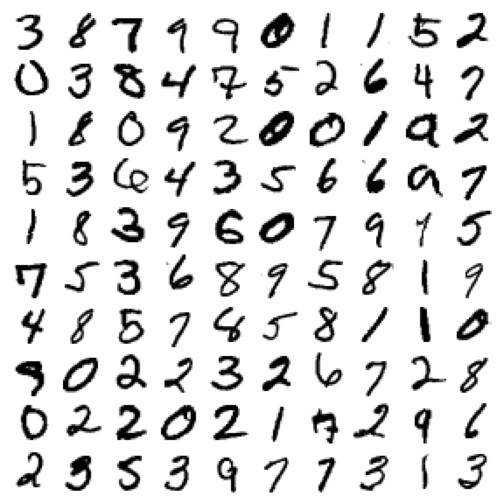

In [27]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

# ¡A ustedes!

1. Definan un modelo simple (no más de tres capas convolucionales)
2. Compilen con la función de pérdida adecuada y un optimizador que prefieran.
3. Entrenen usando algún callback razonable.

Algunas cosas que pueden usar:

In [ ]:
keras.layers.Conv2D?

In [ ]:
keras.layers.MaxPooling2D?

In [ ]:
keras.layers.AveragePooling2D?

In [ ]:
keras.layers.Dropout?

# Extra. Data Augmentation

An important part of the problem that the network has to learn to classify digits correctly are certain symmetries. This is also true for many problems in image recognition.

In other words, if a number "3" was slightly rotated or shifted, we should still be able to recognise it as a three. One way to enforce these symmetries in the network is to feed it with transformed version of the data.

At the same time, this allows increasing the size of the training set.

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Define a data generator that shifts the image horizontally by 5% of its size
datagen = ImageDataGenerator(width_shift_range=[-0.05,0.05])

# Image data generator expects an array of rank 4
print(X_train[1].reshape(1, 28, 28).shape)

X_train_dg = np.expand_dims(X_train[1].reshape(1, 28, 28), axis=[-1,])
print(X_train_dg.shape)

# expand dimension to one sample
# samples = np.expand_dims(data, 0)

# Prepare iterator with training set
it = datagen.flow(X_train_dg, batch_size=1)

plt.figure(figsize=(8, 8))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    plt.imshow(image, cmap='gray')
    plt.axis('off')

We can equivalently add a vertical shift

In [ ]:
# Define a data generator that shifts the image horizontally and vertically by 5% of its size
datagen = ImageDataGenerator(width_shift_range=[-0.05,0.05], height_shift_range=[-0.05, 0.05])

# Prepare iterator with training set
it = datagen.flow(X_train_dg, batch_size=1)

plt.figure(figsize=(8, 8))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    plt.imshow(image, cmap='gray')
    plt.axis('off')

And a small rotation

In [ ]:
# Define a data generator that shifts the image horizontally and vertically by 5% of its size
# and a rotation of at most 20 degrees
datagen = ImageDataGenerator(width_shift_range=[-0.05,0.05], height_shift_range=[-0.05, 0.05],
                             rotation_range=20)

# Prepare iterator with training set
it = datagen.flow(X_train_dg, batch_size=1)

plt.figure(figsize=(8, 8))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    plt.imshow(image, cmap='gray')
    plt.axis('off')

And some zoom

In [ ]:
# Define a data generator that shifts the image horizontally and vertically by 5% of its size
# and a rotation of at most 20 degrees
datagen = ImageDataGenerator(width_shift_range=[-0.05,0.05], height_shift_range=[-0.05, 0.05],
                             rotation_range=20, zoom_range=0.05)

# Prepare iterator with training set
it = datagen.flow(X_train_dg, batch_size=1)

plt.figure(figsize=(8, 8))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    plt.imshow(image, cmap='gray')
    plt.axis('off')

There are many additional options to the `ImageDataGenerator` class

In [ ]:
ImageDataGenerator?

## Fitting a model with augemented datasets

We can now simply fit the same model as above with the augmented dataset.

In [ ]:
model_fc = keras.models.Sequential()

# Input layer
model_fc.add(keras.layers.Flatten(input_shape=(28,28,1)))

# Twi hidden layers with 32 units each
model_fc.add(keras.layers.Dense(32, activation='relu'))
model_fc.add(keras.layers.Dense(32, activation='relu'))

# Output layer. As this is a multi-class classification problem, use K (here 10) units.
model_fc.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model_fc.compile(loss='categorical_crossentropy', 
                  metrics=['accuracy',])

In [ ]:
epochs = 100
batch_size = 32

# Increase dimensions of X_train to fit data generator
X_4c = np.expand_dims(X_train, axis=-1)

# Prepare data generator
datagen = ImageDataGenerator(width_shift_range=[-0.05,0.05], height_shift_range=[-0.05, 0.05],
                             rotation_range=20, zoom_range=0.05)



model_fc.fit(datagen.flow(X_4c, t_train_ohe, batch_size=batch_size), 
             steps_per_epoch=np.ceil(len(X_train) / batch_size), epochs=epochs)

# which actually does this
# for e in range(epochs):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in datagen.flow(X_train, t_train, batch_size=32):
#         model.fit(x_batch, y_batch)
#         batches += 1
#         if batches >= ceil(len(x_train) / batch_size):
#             # we need to break the loop by hand because
#             # the generator loops indefinitely
#             break